# ECE 271A - HW1: Bayesian Classifier for Image Segmentation

This notebook implements a Bayesian classifier to segment a cheetah from a grassy background. The process involves estimating prior and class-conditional probabilities from training data and then applying the Bayes Decision Rule to a test image.

### Step 1: Imports and Data Loading
First, import the necessary libraries and load all required data: the training samples, the zig-zag pattern for DCT coefficient ordering, and the test image with its ground truth mask.

In [41]:
import numpy as np
from scipy.io import loadmat
from scipy.fft import dctn
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# Load training data, zig-zag pattern, and test images
training_data = loadmat('TrainingSamplesDCT_8.mat')
TrainsampleDCT_FG = training_data['TrainsampleDCT_FG']
TrainsampleDCT_BG = training_data['TrainsampleDCT_BG']

zigzag_pattern = np.loadtxt('Zig-Zag Pattern.txt', dtype=int)

image = imageio.imread('cheetah.bmp', pilmode='L')
mask_true = imageio.imread('cheetah_mask.bmp')

print("Data loaded successfully.")
print(f"\nData Information:")
print(f"  - Foreground (cheetah) samples: {TrainsampleDCT_FG.shape[0]}")
print(f"  - Background (grass) samples: {TrainsampleDCT_BG.shape[0]}")
print(f"  - Test image size: {image.shape}")
print(f"  - Ground truth mask size: {mask_true.shape}")

Data loaded successfully.

Data Information:
  - Foreground (cheetah) samples: 250
  - Background (grass) samples: 1053
  - Test image size: (255, 270)
  - Ground truth mask size: (255, 270)


### Step 2 (Part a): Estimate Prior Probabilities

The prior probabilities $P(Y=\text{cheetah})$ and $P(Y=\text{grass})$ are estimated based on the proportion of samples for each class in the training set.

In [42]:
n_fg = TrainsampleDCT_FG.shape[0]
n_bg = TrainsampleDCT_BG.shape[0]
n_total = n_fg + n_bg

prior_cheetah = n_fg / n_total
prior_grass = n_bg / n_total

print(f"Part (a): Prior Probabilities")
print(f"P(Y=cheetah) = {n_fg}/{n_total} = {prior_cheetah:.4f}")
print(f"P(Y=grass)   = {n_bg}/{n_total} = {prior_grass:.4f}")

Part (a): Prior Probabilities
P(Y=cheetah) = 250/1303 = 0.1919
P(Y=grass)   = 1053/1303 = 0.8081


### Step 3 (Part b): Estimate Class-Conditional Probabilities (Likelihoods)

The feature for classification is the 1-based index of the DCT coefficient with the second-largest magnitude. Estimate the likelihoods $P(X|Y)$ by creating a normalized histogram of these features for each class. Laplace smoothing is applied to ensure robustness against zero-count bins.

In [43]:
def extract_features(data):
    """
    Extracts the index of the 2nd largest absolute DCT coefficient for each sample.
    """
    abs_data = np.abs(data)
    sorted_indices = np.argsort(abs_data, axis=1)[:, ::-1]
    # Return the second column (index of 2nd largest) + 1 for 1-based indexing
    return sorted_indices[:, 1] + 1

# Extract features for both classes
features_fg = extract_features(TrainsampleDCT_FG)
features_bg = extract_features(TrainsampleDCT_BG)

# Create histograms for likelihood estimation (bins from 1 to 64)
bins = np.arange(1, 66)
hist_fg, _ = np.histogram(features_fg, bins=bins)
hist_bg, _ = np.histogram(features_bg, bins=bins)

# Estimate likelihoods with Laplace smoothing
epsilon = 1e-9
likelihood_cheetah = (hist_fg + epsilon) / (n_fg + epsilon * 64)
likelihood_grass = (hist_bg + epsilon) / (n_bg + epsilon * 64)

print("Part (b): Likelihood Estimation")
print(f"Sum of P(X|Y=cheetah): {np.sum(likelihood_cheetah):.6f}")
print(f"Sum of P(X|Y=grass):   {np.sum(likelihood_grass):.6f}")

Part (b): Likelihood Estimation
Sum of P(X|Y=cheetah): 1.000000
Sum of P(X|Y=grass):   1.000000


#### Visualize Likelihoods

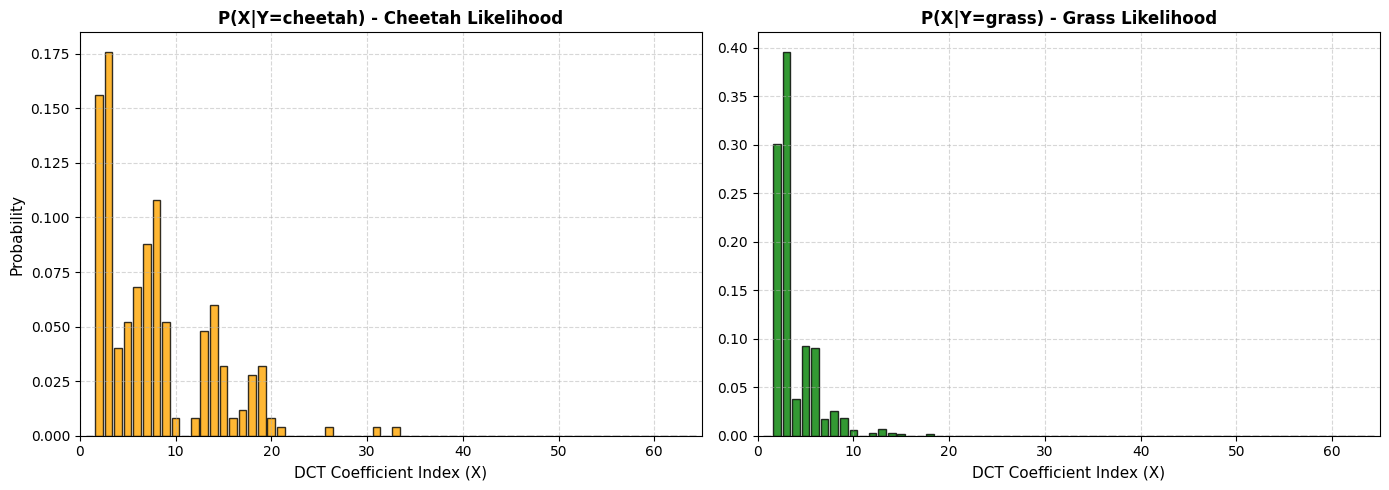

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(np.arange(1, 65), likelihood_cheetah, color='orange', alpha=0.8, edgecolor='black')
ax1.set_title('P(X|Y=cheetah) - Cheetah Likelihood', fontsize=12, fontweight='bold')
ax1.set_xlabel('DCT Coefficient Index (X)', fontsize=11)
ax1.set_ylabel('Probability', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xlim(0, 65)

ax2.bar(np.arange(1, 65), likelihood_grass, color='green', alpha=0.8, edgecolor='black')
ax2.set_title('P(X|Y=grass) - Grass Likelihood', fontsize=12, fontweight='bold')
ax2.set_xlabel('DCT Coefficient Index (X)', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xlim(0, 65)

plt.tight_layout()
plt.savefig('hw1_likelihoods.png', dpi=150)
plt.show()

### Step 4 (Part c): Image Segmentation
We process the test image using a sliding 8x8 window. For each block, we extract its feature and classify it using the Bayes Decision Rule. The classification result is assigned to the center pixel of the block in a new mask with the same dimensions as the original image. Finally, we fill the boundary pixels using nearest-neighbor interpolation.

In [45]:
image_float = image.astype(np.float64) / 255.0
height, width = image.shape
block_size = 8

# Create a segmentation mask with the same dimensions as the original image
segmentation_mask = np.zeros((height, width), dtype=np.uint8)

# Create an inverse mapping for the zig-zag scan for efficiency
zigzag_flat = zigzag_pattern.flatten()
inverse_zigzag = np.empty_like(zigzag_flat)
inverse_zigzag[zigzag_flat] = np.arange(len(zigzag_flat))

print("Part (c): Segmenting image...")
total_blocks = (height - block_size + 1) * (width - block_size + 1)

# Iterate through the image with a sliding window
for i in range(height - block_size + 1):
    if (i + 1) % 25 == 0:
        print(f"  Processing row {i+1}/{height - block_size + 1}...")
    for j in range(width - block_size + 1):
        block = image_float[i:i + block_size, j:j + block_size]
        dct_block = dctn(block, type=2, norm='ortho')
        dct_vector = dct_block.flatten()[inverse_zigzag]
        feature_idx = np.argsort(np.abs(dct_vector))[::-1][1] + 1
        
        # Bayes Decision Rule in log-space for numerical stability
        log_post_cheetah = np.log(prior_cheetah) + np.log(likelihood_cheetah[feature_idx - 1])
        log_post_grass = np.log(prior_grass) + np.log(likelihood_grass[feature_idx - 1])

        # Assign classification to the center pixel of the block
        center_i, center_j = i + block_size // 2, j + block_size // 2
        if log_post_cheetah > log_post_grass:
            segmentation_mask[center_i, center_j] = 1 # Cheetah
        else:
            segmentation_mask[center_i, center_j] = 0 # Grass

# Fill boundary pixels using nearest neighbor interpolation
half_block = block_size // 2
segmentation_mask[:half_block, :] = segmentation_mask[half_block:half_block+1, :]
segmentation_mask[-half_block:, :] = segmentation_mask[-half_block-1:-half_block, :]
segmentation_mask[:, :half_block] = segmentation_mask[:, half_block:half_block+1]
segmentation_mask[:, -half_block:] = segmentation_mask[:, -half_block-1:-half_block]
print("Boundary pixels filled.")

Part (c): Segmenting image...
  Processing row 25/248...
  Processing row 50/248...
  Processing row 75/248...
  Processing row 100/248...
  Processing row 125/248...
  Processing row 150/248...
  Processing row 175/248...
  Processing row 200/248...
  Processing row 225/248...
Boundary pixels filled.


#### Visualize Segmentation Results

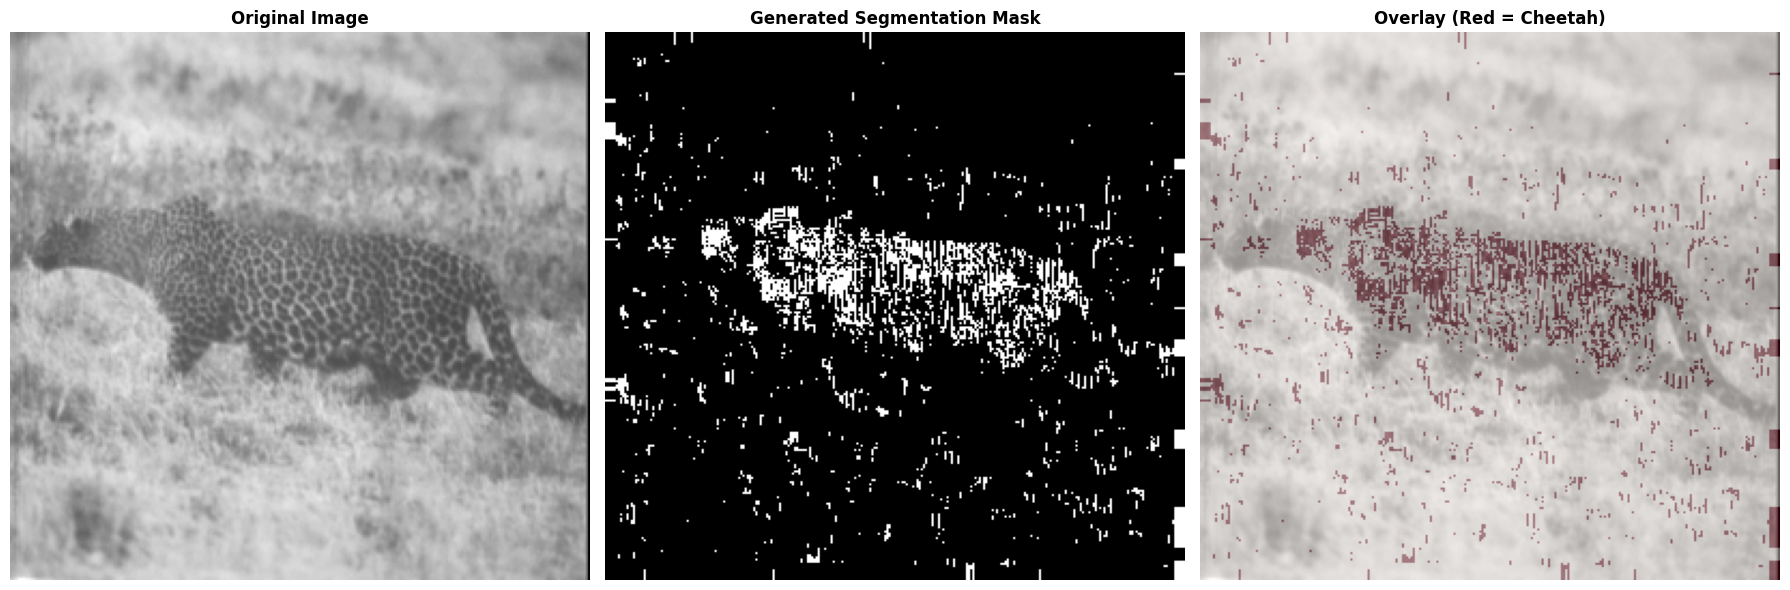

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(segmentation_mask, cmap='gray')
ax2.set_title('Generated Segmentation Mask', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3.imshow(image, cmap='gray')
ax3.imshow(segmentation_mask, cmap='Reds', alpha=0.4)
ax3.set_title('Overlay (Red = Cheetah)', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.savefig('hw1_segmentation_result.png', dpi=150)
plt.show()

### Step 5 (Part d): Probability of Error and Performance Analysis
The performance of the classifier is evaluated by comparing the generated segmentation mask against the ground truth. We calculate the probability of error, a confusion matrix, and key metrics like precision and recall for the 'cheetah' class.

In [47]:
# Convert ground truth mask to binary (0 or 1)
mask_true_binary = (mask_true / 255).astype(np.uint8)

# Calculate probability of error
mismatched_pixels = np.sum(segmentation_mask != mask_true_binary)
total_pixels = mask_true_binary.size
error_rate = mismatched_pixels / total_pixels

print("Part (d): Probability of Error Analysis")
print("="*40)
print(f"Total Pixels:         {total_pixels:,}")
print(f"Mismatched Pixels:    {mismatched_pixels:,}")
print(f"Correctly Classified: {total_pixels - mismatched_pixels:,}")
print(f"\n>>> Probability of Error: {error_rate:.4f} ({error_rate * 100:.2f}%) <<<")
print("="*40)

# Compute Confusion Matrix
true_positive = np.sum((segmentation_mask == 1) & (mask_true_binary == 1))
true_negative = np.sum((segmentation_mask == 0) & (mask_true_binary == 0))
false_positive = np.sum((segmentation_mask == 1) & (mask_true_binary == 0))
false_negative = np.sum((segmentation_mask == 0) & (mask_true_binary == 1))

print("\nConfusion Matrix:")
print(f"  True Positive (Cheetah):  {true_positive:>6,}")
print(f"  True Negative (Grass):    {true_negative:>6,}")
print(f"  False Positive (Type I):  {false_positive:>6,}")
print(f"  False Negative (Type II): {false_negative:>6,}")

# Compute Precision and Recall
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(f"Precision (Cheetah): {precision:.4f}")
print(f"Recall (Cheetah):    {recall:.4f}")

Part (d): Probability of Error Analysis
Total Pixels:         68,850
Mismatched Pixels:    11,888
Correctly Classified: 56,962

>>> Probability of Error: 0.1727 (17.27%) <<<

Confusion Matrix:
  True Positive (Cheetah):   3,329
  True Negative (Grass):    53,633
  False Positive (Type I):   2,008
  False Negative (Type II):  9,880
Precision (Cheetah): 0.6238
Recall (Cheetah):    0.2520


#### Visualize Error Analysis

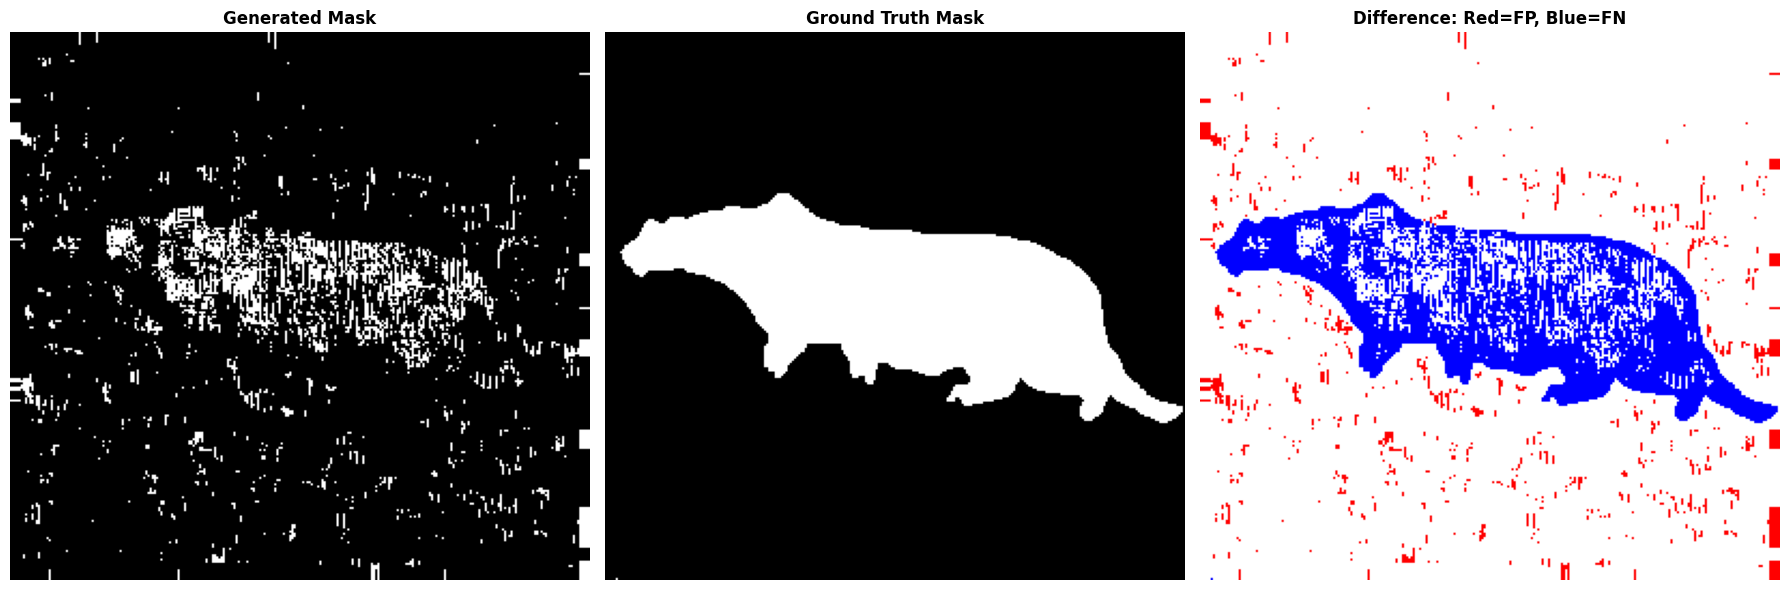

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(segmentation_mask, cmap='gray')
ax1.set_title('Generated Mask', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(mask_true_binary, cmap='gray')
ax2.set_title('Ground Truth Mask', fontsize=12, fontweight='bold')
ax2.axis('off')

# Create a color-coded difference map
difference = np.zeros((*segmentation_mask.shape, 3))
difference[segmentation_mask == mask_true_binary] = [1, 1, 1]  # White: Correct
difference[(segmentation_mask == 1) & (mask_true_binary == 0)] = [1, 0, 0]  # Red: False Positive
difference[(segmentation_mask == 0) & (mask_true_binary == 1)] = [0, 0, 1]  # Blue: False Negative
ax3.imshow(difference)
ax3.set_title(f'Difference: Red=FP, Blue=FN', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.savefig('hw1_error_analysis.png', dpi=150)
plt.show()